# NLP test

In [201]:
import sqlite3
import matplotlib.pyplot as plt
import pickle
import sklearn
import numpy as np
import pandas as pd
import collections
import sqlite3
import re
% matplotlib inline

In [14]:
# obj 生成
conn = sqlite3.connect('reviews.sqlite3')
cur = conn.cursor()

cur.execute("select content from spams")
obj = cur.fetchall()

conn.commit()
conn.close()

In [24]:
# 形態素解析Mecab + neologd版
import MeCab

mecab = MeCab.Tagger ('-d /usr/local/lib/mecab/dic/mecab-ipadic-neologd')

# art="080-3322-9382に電話かけてください"
res = []
for art in obj:
    art = art[0]
    mecab.parse("")
    res.append((len(mecab.parse(art).split())-1)/2)

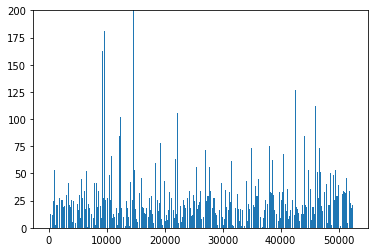

In [29]:
plt.figure()
plt.bar(np.arange(len(res)),res)
plt.ylim(0,200)
plt.show()

In [31]:
print(np.mean(np.array(res)),np.std(np.array(res)),np.min(np.array(res)),np.max(np.array(res)))

31.1362605747 38.4226533099 0.0 1410.0


In [30]:
whitelist = "\n「」。、あいうえおかきくけこさしすせそたちつてとなにぬねのはひふへほまみむめもやゐゆゑよらりるれろわをんがぎぐげござじずぜぞだぢづでどばびぶべぼぱぴぷぺぽぁぃぅぇぉゃゅょっゎ"
whitelist = set(whitelist)

In [203]:
'''
形態素解析Mecab + neologd版
all_dataはsentenceごとのひらがな分かち書き
whitelistの単語のみ許容
sentece末尾に終端文字を入れる
'''

import MeCab
import jaconv

mecab = MeCab.Tagger ('-d /usr/local/lib/mecab/dic/mecab-ipadic-neologd')   #for mac
# mecab = MeCab.Tagger ('-d /usr/lib/mecab/dic/mecab-ipadic-neologd') # for ubuntu

sentence_num = 10000

all_data = []
for art in obj[:sentence_num]:
    art = art[0]
    
    mecab.parse("")    
    node = mecab.parseToNode(art)
    
    tmp_data = []
    while node:
        #単語を取得
        word = node.surface
        #品詞を取得
        pos = node.feature.split(",")

        # 記号とwhitelist以外の単語を弾く
        if pos[0] != '記号':
            word = jaconv.kata2hira(pos[-2])
            if (set(word) - whitelist) == set():
                tmp_data.append(jaconv.kata2hira(pos[-2]))
            
        #次の単語に進める
        node = node.next
        
    # 終端文字挿入
    tmp_data.append("E")
    
    all_data.append(tmp_data)

In [204]:
all_data

[['とうとう',
  'みんしん',
  'は',
  'たてまえ',
  'さえ',
  'も',
  'ほうかい',
  'し',
  'た',
  'の',
  'か',
  'じぶん',
  'の',
  'かんがえ',
  'に',
  'じしん',
  'が',
  'もて',
  'ない',
  'とう',
  'に',
  'めいしょう',
  'かえろ',
  'よ',
  'E'],
 ['じえいたい', 'ぐんたい', 'みとめ', 'て', 'よい', 'はやく', 'みとめよ', 'う', 'E'],
 ['がいじん',
  'なんて',
  'もの',
  'が',
  'そんざい',
  'する',
  'みん',
  'しんとう',
  'が',
  'あんぜんほしょう',
  'かたっ',
  'て',
  'はずかしく',
  'ない',
  'の',
  'か',
  'よ',
  'E'],
 ['まだ', 'みたい', 'な', 'こと', 'いっ', 'て', 'て', 'びっくり', 'だ', 'わ', 'E'],
 ['おんけんほしゅ',
  'わろた',
  'おまえ',
  'ら',
  'みんきょう',
  'がったい',
  'の',
  'きょくさせいとう',
  'だろ',
  'う',
  'が',
  'みんきょう',
  'がったい',
  'で',
  'とくあ',
  'だ',
  'E'],
 ['いま',
  'まで',
  'みんしんとう',
  'が',
  'どういう',
  'かぜ',
  'に',
  'しゅちょう',
  'し',
  'て',
  'こっかい',
  'を',
  'くうてん',
  'さ',
  'せ',
  'て',
  'き',
  'た',
  'か',
  'わすれ',
  'た',
  'の',
  'ぶれ',
  'てる',
  'どころ',
  'の',
  'はなし',
  'じゃ',
  'ない',
  'ばっち',
  'を',
  'つけ',
  'たい',
  'だけ',
  'の',
  'ぎいん',
  'なんか',
  'いら',
  'ねぇ',
  'E'],
 ['いま',
  'の',
  'しじしゃ',
  'が',
  

In [240]:
'''
全単語の辞書とword2vec作成
'''

all_word = []
for s in all_data:
    all_word.extend(s)
    
# 全単語ベクトル
word_id_dict = {k:v for v,k in enumerate(list(set(all_word)))}
id_word_dict = {k:v for v,k in word_id_dict.items()}
word_num = len(word_id_dict)

with open("corpus.txt","w") as f:
    for i in all_word:
        f.write(i+" ")

# word2vec
from gensim.models import word2vec

sentences = word2vec.Text8Corpus('corpus.txt')

word_model = word2vec.Word2Vec(sentences,
                          sg=1,
                          size=200,
                          min_count=1,
                          window=10,
                          hs=1,
                          negative=0)


In [260]:
# sentenceごと，trigramのx_dataと次の単語のy_data生成

x_data = []
y_data = []
for s in all_data:
    s_len = len(s)
    if s_len < 4:
        continue
    trigram = []
    next_word = []
    for i in range(s_len - 3):
        trigram.append(s[i:i+3])
        next_word.append(word_id_dict[s[i+3]])
    print(s)
    print(trigram)
    x_data.extend([[word_model[y] for y in x] for x in trigram])
    y_data.extend(next_word)
x_data = np.array(x_data)
y_data = np.array(y_data)

['とうとう', 'みんしん', 'は', 'たてまえ', 'さえ', 'も', 'ほうかい', 'し', 'た', 'の', 'か', 'じぶん', 'の', 'かんがえ', 'に', 'じしん', 'が', 'もて', 'ない', 'とう', 'に', 'めいしょう', 'かえろ', 'よ', 'E']
[['とうとう', 'みんしん', 'は'], ['みんしん', 'は', 'たてまえ'], ['は', 'たてまえ', 'さえ'], ['たてまえ', 'さえ', 'も'], ['さえ', 'も', 'ほうかい'], ['も', 'ほうかい', 'し'], ['ほうかい', 'し', 'た'], ['し', 'た', 'の'], ['た', 'の', 'か'], ['の', 'か', 'じぶん'], ['か', 'じぶん', 'の'], ['じぶん', 'の', 'かんがえ'], ['の', 'かんがえ', 'に'], ['かんがえ', 'に', 'じしん'], ['に', 'じしん', 'が'], ['じしん', 'が', 'もて'], ['が', 'もて', 'ない'], ['もて', 'ない', 'とう'], ['ない', 'とう', 'に'], ['とう', 'に', 'めいしょう'], ['に', 'めいしょう', 'かえろ'], ['めいしょう', 'かえろ', 'よ']]
['じえいたい', 'ぐんたい', 'みとめ', 'て', 'よい', 'はやく', 'みとめよ', 'う', 'E']
[['じえいたい', 'ぐんたい', 'みとめ'], ['ぐんたい', 'みとめ', 'て'], ['みとめ', 'て', 'よい'], ['て', 'よい', 'はやく'], ['よい', 'はやく', 'みとめよ'], ['はやく', 'みとめよ', 'う']]
['がいじん', 'なんて', 'もの', 'が', 'そんざい', 'する', 'みん', 'しんとう', 'が', 'あんぜんほしょう', 'かたっ', 'て', 'はずかしく', 'ない', 'の', 'か', 'よ', 'E']
[['がいじん', 'なんて', 'もの'], ['なんて', 'もの', 'が'], ['もの', 'が', 'そんざい'], ['が', 'そんざい', '

['そろそろ', 'ばくげき', 'し', 'とけ', 'や', 'E']
[['そろそろ', 'ばくげき', 'し'], ['ばくげき', 'し', 'とけ'], ['し', 'とけ', 'や']]
['みさいる', 'だい', 'かせが', 'なきゃ', 'だ', 'から', 'な', 'E']
[['みさいる', 'だい', 'かせが'], ['だい', 'かせが', 'なきゃ'], ['かせが', 'なきゃ', 'だ'], ['なきゃ', 'だ', 'から'], ['だ', 'から', 'な']]
['ぱよく', 'の', 'しこうかいろ', 'また', 'たのむ', 'せい', 'おん', 'せい', 'おん', 'やれ', 'いか', 'づり', 'ちょうせん', 'せんちょう', 'はい', 'E']
[['ぱよく', 'の', 'しこうかいろ'], ['の', 'しこうかいろ', 'また'], ['しこうかいろ', 'また', 'たのむ'], ['また', 'たのむ', 'せい'], ['たのむ', 'せい', 'おん'], ['せい', 'おん', 'せい'], ['おん', 'せい', 'おん'], ['せい', 'おん', 'やれ'], ['おん', 'やれ', 'いか'], ['やれ', 'いか', 'づり'], ['いか', 'づり', 'ちょうせん'], ['づり', 'ちょうせん', 'せんちょう'], ['ちょうせん', 'せんちょう', 'はい']]
['なにひとつ', 'まとも', 'に', 'でき', 'ない', 'にっぽんせいふ', 'むのう', 'の', 'きわみ', 'きのう', 'し', 'て', 'い', 'ない', 'の', 'なら', 'そんざい', 'かち', 'ない', 'ね', 'E']
[['なにひとつ', 'まとも', 'に'], ['まとも', 'に', 'でき'], ['に', 'でき', 'ない'], ['でき', 'ない', 'にっぽんせいふ'], ['ない', 'にっぽんせいふ', 'むのう'], ['にっぽんせいふ', 'むのう', 'の'], ['むのう', 'の', 'きわみ'], ['の', 'きわみ', 'きのう'], ['きわみ', 'きのう', 'し'], ['きのう', 'し',

[['ここ', 'で', 'じさつ'], ['で', 'じさつ', 'に'], ['じさつ', 'に', 'みえる'], ['に', 'みえる', 'よう'], ['みえる', 'よう', 'に'], ['よう', 'に', 'ゆうあい'], ['に', 'ゆうあい', 'し'], ['ゆうあい', 'し', 'て'], ['し', 'て', 'と'], ['て', 'と', 'わめく'], ['と', 'わめく', 'かも'], ['わめく', 'かも', 'しれ'], ['かも', 'しれ', 'ん'], ['しれ', 'ん', 'な'], ['ん', 'な', 'もう'], ['な', 'もう', 'これ'], ['もう', 'これ', 'くらい'], ['これ', 'くらい', 'しか'], ['くらい', 'しか', 'の'], ['しか', 'の', 'つかいみち'], ['の', 'つかいみち', 'は'], ['つかいみち', 'は', 'ない'], ['は', 'ない', 'だろ']]
['とうきょうせんきょく', 'の', 'ゆうけんしゃ', 'が', 'うったえれ', 'ば', 'よい', 'です', 'よ', 'E']
[['とうきょうせんきょく', 'の', 'ゆうけんしゃ'], ['の', 'ゆうけんしゃ', 'が'], ['ゆうけんしゃ', 'が', 'うったえれ'], ['が', 'うったえれ', 'ば'], ['うったえれ', 'ば', 'よい'], ['ば', 'よい', 'です'], ['よい', 'です', 'よ']]
['しら', 'なかっ', 'た', 'ん', 'だ', 'もん', 'いいんじゃない', 'の', 'きょぎ', 'ある', 'E']
[['しら', 'なかっ', 'た'], ['なかっ', 'た', 'ん'], ['た', 'ん', 'だ'], ['ん', 'だ', 'もん'], ['だ', 'もん', 'いいんじゃない'], ['もん', 'いいんじゃない', 'の'], ['いいんじゃない', 'の', 'きょぎ'], ['の', 'きょぎ', 'ある']]
['おまえ', 'は', 'まいにち', 'まいにち', 'はたらき', 'も', 'せ', 'ず', 'に', 'なん', 'じかん', 'も

[['れんほう', 'よ', 'ほんとうに'], ['よ', 'ほんとうに', 'いま'], ['ほんとうに', 'いま', 'まで'], ['いま', 'まで', 'しら'], ['まで', 'しら', 'なかっ'], ['しら', 'なかっ', 'た'], ['なかっ', 'た', 'なら'], ['た', 'なら', 'こくみん'], ['なら', 'こくみん', 'の'], ['こくみん', 'の', 'こと'], ['の', 'こと', 'さべつ'], ['こと', 'さべつ', 'しゅぎしゃ'], ['さべつ', 'しゅぎしゃ', 'よばわり'], ['しゅぎしゃ', 'よばわり', 'し'], ['よばわり', 'し', 'て'], ['し', 'て', 'まで'], ['て', 'まで', 'こせき'], ['まで', 'こせき', 'かくす'], ['こせき', 'かくす', 'ひつよう'], ['かくす', 'ひつよう', 'は'], ['ひつよう', 'は', 'なかっ'], ['は', 'なかっ', 'た'], ['なかっ', 'た', 'よ'], ['た', 'よ', 'な'], ['よ', 'な', 'あああああ'], ['な', 'あああああ', 'ちょうせんじん'], ['あああああ', 'ちょうせんじん', 'と'], ['ちょうせんじん', 'と', 'れんほう'], ['と', 'れんほう', 'は'], ['れんほう', 'は', 'すぐ'], ['は', 'すぐ', 'ばれる'], ['すぐ', 'ばれる', 'うそ'], ['ばれる', 'うそ', 'を'], ['うそ', 'を', 'つく']]
['すぱい', 'が', 'のばなし', 'で', 'ぎいん', 'まで', 'やれる', 'ぶた', 'も', 'ひょう', 'さえ', 'あつまれ', 'ば', 'ぎいん', 'に', 'なれる', 'そんな', 'にっぽん', 'が', 'しんそこ', 'E']
[['すぱい', 'が', 'のばなし'], ['が', 'のばなし', 'で'], ['のばなし', 'で', 'ぎいん'], ['で', 'ぎいん', 'まで'], ['ぎいん', 'まで', 'やれる'], ['まで', 'やれる', 'ぶた'], ['やれ

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


[['かんばん', 'だけ', 'げ'], ['だけ', 'げ', 'かえ'], ['げ', 'かえ', 'て'], ['かえ', 'て', 'あたらしい'], ['て', 'あたらしい', 'とう'], ['あたらしい', 'とう', 'の'], ['とう', 'の', 'ふり'], ['の', 'ふり', 'し'], ['ふり', 'し', 'て'], ['し', 'て', 'さぎ'], ['て', 'さぎ', 'しよ'], ['さぎ', 'しよ', 'う'], ['しよ', 'う', 'ってか'], ['う', 'ってか', 'どんだけ'], ['ってか', 'どんだけ', 'こくみん'], ['どんだけ', 'こくみん', 'を'], ['こくみん', 'を', 'ばか'], ['を', 'ばか', 'に'], ['ばか', 'に', 'し'], ['に', 'し', 'て'], ['し', 'て', 'ん'], ['て', 'ん', 'だ'], ['ん', 'だ', 'この'], ['だ', 'この', 'やろう']]
['こんど', 'は', 'こくみんとう', 'に', 'でも', 'する', 'かい', 'E']
[['こんど', 'は', 'こくみんとう'], ['は', 'こくみんとう', 'に'], ['こくみんとう', 'に', 'でも'], ['に', 'でも', 'する'], ['でも', 'する', 'かい']]
['こんど', 'は', 'こくみんとう', 'に', 'でも', 'する', 'かい', 'な', 'E']
[['こんど', 'は', 'こくみんとう'], ['は', 'こくみんとう', 'に'], ['こくみんとう', 'に', 'でも'], ['に', 'でも', 'する'], ['でも', 'する', 'かい'], ['する', 'かい', 'な']]
['であいけい', 'しんとう', 'が', 'おにあい', 'じゃあ', 'ない', 'E']
[['であいけい', 'しんとう', 'が'], ['しんとう', 'が', 'おにあい'], ['が', 'おにあい', 'じゃあ'], ['おにあい', 'じゃあ', 'ない']]
['いしば', 'まえはら', 'じ', 'すすむ', 'とう', 'E']
[['

['なに', 'も', 'しんぱい', 'する', 'こと', 'は', 'ない', 'にっぽん', 'に', 'は', 'いかん', 'ほう', 'が', 'ある', 'E']
[['なに', 'も', 'しんぱい'], ['も', 'しんぱい', 'する'], ['しんぱい', 'する', 'こと'], ['する', 'こと', 'は'], ['こと', 'は', 'ない'], ['は', 'ない', 'にっぽん'], ['ない', 'にっぽん', 'に'], ['にっぽん', 'に', 'は'], ['に', 'は', 'いかん'], ['は', 'いかん', 'ほう'], ['いかん', 'ほう', 'が'], ['ほう', 'が', 'ある']]
['いち', 'はつ', 'なら', 'あやま', 'い', 'な', 'ので', 'うっ', 'て', 'しずめ', 'て', 'しまえ', 'あぁ', 'その', 'まえ', 'に', 'かるく', 'かくみさいる', 'つくっ', 'ちまお', 'う', 'ぜ', 'E']
[['いち', 'はつ', 'なら'], ['はつ', 'なら', 'あやま'], ['なら', 'あやま', 'い'], ['あやま', 'い', 'な'], ['い', 'な', 'ので'], ['な', 'ので', 'うっ'], ['ので', 'うっ', 'て'], ['うっ', 'て', 'しずめ'], ['て', 'しずめ', 'て'], ['しずめ', 'て', 'しまえ'], ['て', 'しまえ', 'あぁ'], ['しまえ', 'あぁ', 'その'], ['あぁ', 'その', 'まえ'], ['その', 'まえ', 'に'], ['まえ', 'に', 'かるく'], ['に', 'かるく', 'かくみさいる'], ['かるく', 'かくみさいる', 'つくっ'], ['かくみさいる', 'つくっ', 'ちまお'], ['つくっ', 'ちまお', 'う'], ['ちまお', 'う', 'ぜ']]
['えんがん', 'こく', 'の', 'ぼうえい', 'または', 'あんぜん', 'に', 'えいきょう', 'を', 'あたえる', 'こと', 'を', 'もくてき', 'と', 'する', 'せんでん', 'こうい'

[['しんよう', 'でき', 'ない'], ['でき', 'ない', 'ひと']]
['た', 'の', 'とういん', 'と', 'くらべる', 'と', 'ものすごく', 'まとも', 'な', 'こと', 'いっ', 'てる', 'よう', 'な', 'き', 'に', 'なっ', 'て', 'しまう', 'た', 'が', 'どんだけ', 'くさっ', 'てる', 'か', 'だ', 'な', 'E']
[['た', 'の', 'とういん'], ['の', 'とういん', 'と'], ['とういん', 'と', 'くらべる'], ['と', 'くらべる', 'と'], ['くらべる', 'と', 'ものすごく'], ['と', 'ものすごく', 'まとも'], ['ものすごく', 'まとも', 'な'], ['まとも', 'な', 'こと'], ['な', 'こと', 'いっ'], ['こと', 'いっ', 'てる'], ['いっ', 'てる', 'よう'], ['てる', 'よう', 'な'], ['よう', 'な', 'き'], ['な', 'き', 'に'], ['き', 'に', 'なっ'], ['に', 'なっ', 'て'], ['なっ', 'て', 'しまう'], ['て', 'しまう', 'た'], ['しまう', 'た', 'が'], ['た', 'が', 'どんだけ'], ['が', 'どんだけ', 'くさっ'], ['どんだけ', 'くさっ', 'てる'], ['くさっ', 'てる', 'か'], ['てる', 'か', 'だ'], ['か', 'だ', 'な']]
['たいとる', 'み', 'て', 'はな', 'で', 'わらっ', 'た', 'わ', 'E']
[['たいとる', 'み', 'て'], ['み', 'て', 'はな'], ['て', 'はな', 'で'], ['はな', 'で', 'わらっ'], ['で', 'わらっ', 'た'], ['わらっ', 'た', 'わ']]
['なん', 'だ', 'よ', 'こいつ', 'みんしゅ', 'から', 'いしん', 'そして', 'みんしん', 'の', 'ひと', 'いらん', 'わ', 'E']
[['なん', 'だ', 'よ'], ['だ', 'よ', 'こいつ'

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [246]:
print(np.array(x_data).shape)
print(np.array(y_data).shape)
print(len(word_id_dict))

(222951, 3, 200)
(222951,)
14609


In [363]:
# one hot vectorize

x_train = x_data[:10000].reshape(10000,3,200)
y_train = y_data[:10000]
x_test = x_data[10000:12000].reshape(2000,3,200)
y_test = y_data[10000:12000]

# x_train = x_data

# y_train = y_data

from keras.utils import np_utils

nb_classes = len(word_id_dict)

# x_train = np_utils.to_categorical(y_train, nb_classes)
# x_test = np_utils.to_categorical(y_test, nb_classes)

Y_train = np_utils.to_categorical(y_train, nb_classes)
# Y_test = np_utils.to_categorical(y_test, nb_classes)

print("x_train shape:",x_train.shape)
print("Y_train shape:",Y_train.shape)

x_train shape: (10000, 3, 200)
Y_train shape: (10000, 14609)


In [263]:
# LSTM model

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop

model = Sequential()
model.inputs
model.add(LSTM(128, batch_input_shape=(1,3,200), stateful=True))
model.add(Dense(word_num))
model.add(Activation('softmax'))

optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (1, 128)                  168448    
_________________________________________________________________
dense_14 (Dense)             (1, 14609)                1884561   
_________________________________________________________________
activation_14 (Activation)   (1, 14609)                0         
Total params: 2,053,009
Trainable params: 2,053,009
Non-trainable params: 0
_________________________________________________________________


In [264]:
def vec2word(word_vec):
    return word_model.most_similar(positive=[word_vec], topn=1)

In [265]:
print(vec2word(x_train[0][0]))
print(vec2word(x_train[1][0]))

[('とうとう', 0.9999999403953552)]
[('みんしん', 1.0)]


In [266]:
history = model.fit(x_train, Y_train, batch_size=1, epochs=1, shuffle=False)

Epoch 1/1
10000/10000 [==============================] - 337s - loss: 8.3572 - acc: 0.1131   


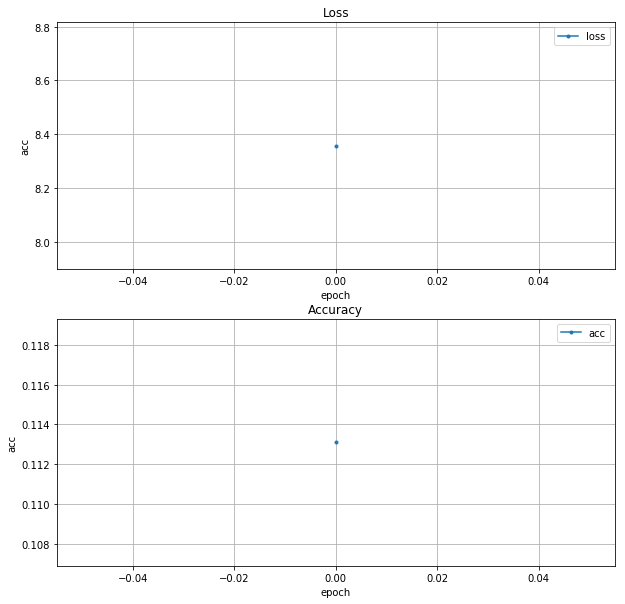

In [267]:
# 学習の様子をプロット
loss = history.history['loss']
# val_loss = history.history['val_loss']

acc = history.history['acc']
# val_acc = history.history['val_acc']

plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.title('Loss')
epochs = len(loss)
plt.plot(range(epochs), loss, marker='.', label='loss')
# plt.plot(range(epochs), val_loss, marker='.', label='val_loss')
plt.legend(loc='best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('acc')

plt.subplot(2,1,2)
plt.title('Accuracy')
plt.plot(range(epochs), acc, marker='.', label='acc')
# plt.plot(range(epochs), val_acc, marker='.', label='val_acc')
plt.legend(loc='best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.show()

In [302]:
all_word

['とうとう',
 'みんしん',
 'は',
 'たてまえ',
 'さえ',
 'も',
 'ほうかい',
 'し',
 'た',
 'の',
 'か',
 'じぶん',
 'の',
 'かんがえ',
 'に',
 'じしん',
 'が',
 'もて',
 'ない',
 'とう',
 'に',
 'めいしょう',
 'かえろ',
 'よ',
 'E',
 'じえいたい',
 'ぐんたい',
 'みとめ',
 'て',
 'よい',
 'はやく',
 'みとめよ',
 'う',
 'E',
 'がいじん',
 'なんて',
 'もの',
 'が',
 'そんざい',
 'する',
 'みん',
 'しんとう',
 'が',
 'あんぜんほしょう',
 'かたっ',
 'て',
 'はずかしく',
 'ない',
 'の',
 'か',
 'よ',
 'E',
 'まだ',
 'みたい',
 'な',
 'こと',
 'いっ',
 'て',
 'て',
 'びっくり',
 'だ',
 'わ',
 'E',
 'おんけんほしゅ',
 'わろた',
 'おまえ',
 'ら',
 'みんきょう',
 'がったい',
 'の',
 'きょくさせいとう',
 'だろ',
 'う',
 'が',
 'みんきょう',
 'がったい',
 'で',
 'とくあ',
 'だ',
 'E',
 'いま',
 'まで',
 'みんしんとう',
 'が',
 'どういう',
 'かぜ',
 'に',
 'しゅちょう',
 'し',
 'て',
 'こっかい',
 'を',
 'くうてん',
 'さ',
 'せ',
 'て',
 'き',
 'た',
 'か',
 'わすれ',
 'た',
 'の',
 'ぶれ',
 'てる',
 'どころ',
 'の',
 'はなし',
 'じゃ',
 'ない',
 'ばっち',
 'を',
 'つけ',
 'たい',
 'だけ',
 'の',
 'ぎいん',
 'なんか',
 'いら',
 'ねぇ',
 'E',
 'いま',
 'の',
 'しじしゃ',
 'が',
 'そんな',
 'こと',
 'のぞん',
 'で',
 'ん',
 'の',
 'あたらしい',
 'しじしゃ',
 'が',
 'その',
 'ほうほう',
 'で',
 'え',
 '

In [369]:
import random

seed = ["この","でんわばんごう","に"]
print(seed)

x = np.array([[word_model[i] for i in seed]])
gen = ""

for i in range(10):
    rn = random.randint(0,2)
    pred_index = np.argsort(model.predict(x)[0])[-(1+rn)]
    
    next_word = id_word_dict[pred_index]
    if next_word == 'E':
        break
        
    gen += " "+next_word
    
    new_seed = seed[1:]
    new_seed.append(next_word)
    seed = new_seed
    print(seed)
    
    x = np.array([[word_model[i] for i in seed]])

print(gen)

['この', 'でんわばんごう', 'に']
['でんわばんごう', 'に', 'は']
['に', 'は', 'は']
['は', 'は', 'は']
['は', 'は', 'は']
['は', 'は', 'は']
['は', 'は', 'て']
['は', 'て', 'て']
['て', 'て', 'て']
['て', 'て', 'は']
['て', 'は', 'て']
 は は は は は て て て は て
